# Henry coefficient Calculations

*TODO:* 
Double check Error Calculations

In [1]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall
using LaTeXStrings

using FileIO
using CSV
using DataFrames

In [2]:
@pyimport adjustText
@pyimport seaborn

In [3]:
# PyPlot.matplotlib.style.use("Solarize_Light2")
PyPlot.matplotlib.style.use("ggplot")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [4]:
@eval PorousMaterials PATH_TO_CRYSTALS=joinpath(pwd(), "structural_relaxation", "post-relaxation_cifs")

"/home/ng/DTRA/structural_relaxation/post-relaxation_cifs"

In [5]:
# # whtat properties do you want to put into the .csv?
# props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

# isotherm filename values
adsorbate = ["Ar", "Kr", "Xe"] 

temp = 298.0 # units: K

pmin = -2 # minimum pessure in log10, units: bar
pmax = 1.1 # maximum pressure (actual value), units: bar
nstep = 15 # number of intervals in pressure range
pressures = 10 .^ range(pmin, stop=log10(pmax), length=nstep)

ljff = LJForceField("UFF"); # "UFF" or "Dreiding"

nburn = 50000 # number of burn cycles
nsample = 50000 # number of sample cycles

insertions_per_volume = 500

functional = ["pbesol", "vdw-df2"]

calculation = "relax"

props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

3-element Array{String,1}:
 "pressure (bar)"
 "fugacity (bar)"
 "⟨N⟩ (mmol/g)"

In [6]:
# MOFs that successfully relaxed and were simulated
xtal_names = [
#     "NiPyC2_vdw-df2-relax.cif",
#     "NiPyC2_pbesol-angle-vc-relax.cif",    
    "NiPyC2_relax_sc211_meta_functionalized_Br_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_C-C_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_CH2-CH3_lammps_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_CH3_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_Cl_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_C-N_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_F_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_N-C-O_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_O-CH3_lammps_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_O-C-N_pbesol_relax.cif",
    "NiPyC2_relax_sc211_meta_functionalized_OH_pbesol_relax.cif",
#     "NiPyC2_relax_sc211_meta_functionalized_O-OH_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_Br_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_C-C_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_CH3_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_Cl_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_C-N_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_F_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_N-C-O_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_NH2_pbesol_relax.cif",
    "NiPyC2_relax_sc211_ortho_functionalized_OH_pbesol_relax.cif"
]

21-element Array{String,1}:
 "NiPyC2_relax_sc211_meta_functionalized_Br_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_C-C_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_CH2-CH3_lammps_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_CH3_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_Cl_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_C-N_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_F_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_N-C-O_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_O-CH3_lammps_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_O-C-N_pbesol_relax.cif"
 "NiPyC2_relax_sc211_meta_functionalized_OH_pbesol_relax.cif"
 "NiPyC2_relax_sc211_ortho_functionalized_Br_pbesol_relax.cif"
 "NiPyC2_relax_sc211_ortho_functionalized_C-C_pbesol_relax.cif"
 "NiPyC2_relax_sc211_ortho_functionalized_CH3_pbesol_relax.cif"
 "NiPy

In [7]:
@eval PorousMaterials PATH_TO_CRYSTALS=joinpath(pwd(), "structural_relaxation", "post-relaxation_cifs")
# initialize results dictionary
dict_gas = Dict{String, Any}()
henry_results = Dict{String, Dict{String, Any}}() # store henry results
isotherm_results = Dict{String, Dict{String, Any}}() # store isotherm results
# sorted_names = Array{String}(undef, length(xtal_names))

for (i, name) in enumerate(xtal_names)     
    # load in crystal structure
    xtal = Crystal(name)
    
    # make a short-hand name for convenience
    if name in ["NiPyC2_vdw-df2-relax.cif", "NiPyC2_pbesol-angle-vc-relax.cif"]
        s_name = split(name, ('_', '.'))[2]
    else
        if occursin("meta", name)
            s_name = "m-" * split(name, ('_', '.'))[6]
        elseif occursin("ortho", name)
            s_name = "o-" * split(name, ('_', '.'))[6]
        else
            @warn "No convention defined for shorthand name for: " name
        end
    end
    
    # correct bad names
    if split(s_name, "-")[2] == "CH3"
        s_name = split(s_name, "-")[1] * "-" * L"CH_3"
    elseif split(s_name, "-")[2] == "O" && split(s_name, "-")[3] == "CH3"
        s_name = split(s_name, "-")[1] * "-" * L"O-CH_3"
    elseif split(s_name, "-")[2] == "CH2"
        if split(s_name, "-")[3] == "CH3"
            s_name = split(s_name, "-")[1] * "-" * L"CH_2-CH_3"
        else
            s_name = split(s_name, "-")[1] * "-" * L"CH_2"
        end        
    elseif split(s_name, "-")[2] == "NH2"
        s_name = split(s_name, "-")[1] * "-" * L"NH_2"
    elseif (s_name == "o-C-C" || s_name == "m-C-C")
        s_name = s_name * "H"
    end
    
    @debug println(s_name)
    # initialize dictionaries
    henry_results[s_name] = Dict{String, Any}()
    isotherm_results[s_name] = Dict{String, Any}()
    
    for gas in adsorbate
        mol = Molecule(gas)
        filename = henry_result_savename(xtal, mol, temp, ljff, insertions_per_volume)
        @debug println(filename*"\n")
        
        # load in the results dictionary
        @load joinpath(PorousMaterials.PATH_TO_SIMS, filename) results
#         henry_results[s_name][gas] = results["henry coefficient [mmol/(g-bar)]"]
        henry_results[s_name][gas] = results
        
        # load isotherm results and store as a DataFrame
        df_sim = isotherm_sim_results_to_dataframe(props_we_want, xtal, mol, temp, 
                                                   pressures, ljff, nburn, nsample)
        push!(df_sim, [0.0, 0.0, 0.0]) ### add point at origin ###
        sort(df_sim, Symbol("pressure (bar)"))
        isotherm_results[s_name][gas] = df_sim
    end
end

In [8]:
# load in the parent mof results
# the crystal file is in a different location than the others
henry_results["Parent MOF"] = Dict{String, Any}()
isotherm_results["Parent MOF"] = Dict{String, Any}()
for gas in adsorbate
    @eval PorousMaterials PATH_TO_CRYSTALS=joinpath(PorousMaterials.PATH_TO_DATA, "crystals")
    xtal = Crystal("NiPyC2_experiment.cif")
    mol = Molecule(gas)
    filename = henry_result_savename(xtal, mol, temp, ljff, insertions_per_volume)
    @debug println(filename*"\n")
    @load joinpath(PorousMaterials.PATH_TO_SIMS, filename) results
    henry_results["Parent MOF"][gas] = results
    
    # load isotherm results and store as a DataFrame
    df_sim = isotherm_sim_results_to_dataframe(props_we_want, xtal, mol, temp, 
                                               pressures, ljff, nburn, nsample)
    push!(df_sim, [0.0, 0.0, 0.0]) ### add point at origin ###
    sort(df_sim, Symbol("pressure (bar)"))
    isotherm_results["Parent MOF"][gas] = df_sim    
end

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/ng/.julia/dev/PorousMaterials/src/crystal.jl:426
┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/ng/.julia/dev/PorousMaterials/src/crystal.jl:426
┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/ng/.julia/dev/PorousMaterials/src/crystal.jl:426


In [9]:
println(henry_results["Parent MOF"]["Xe"]["henry coefficient [mmol/(g-bar)]"], " +/- ",
henry_results["Parent MOF"]["Xe"]["err henry coefficient [mmol/(g-bar)]"])

76.53626627068816 +/- 2.3467489135714557


## Calculating errors in selectivity:
We have the Henry coefficients $ H_{Xe} = h_{Xe} \pm \delta h_{Xe} $, $ H_{Kr} = h_{Kr} \pm \delta h_{Kr}$,  where $h_j$ is the "measured" value and $\delta h_j$ is the associated uncertainty. The Selectivity is calculated as $ S_{Xe/Kr} = s_i \pm \delta s_i$ where $s_i = \frac{h_{Xe}}{h_{Kr}}$. 

To determine the uncertainty of the selectivity $\delta s_i$, we use the fact that the relative errors add in quaderature:
$$ \left(\frac{\delta s_i}{s_i}\right)^2 = \left( \frac{\delta h_{Xe}}{h_{Xe}} \right)^2 + \left( \frac{\delta h_{Kr}}{h_{Kr}} \right)^2  $$

So, 
$$ \delta s_i = s_i\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{\delta h_{Kr}}{h_{Kr}}\right)}^2 } $$

Substituting in the expression for $s_i$, we get:
$$ S_{Xe/Kr} = \frac{h_{Xe}}{h_{Kr}} \pm \frac{h_{Xe}}{h_{Kr}}\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{ \delta h_{Kr}}{h_{Kr}}\right)}^2 }$$

In [10]:
function selectivity_calc(results_dict::Dict{String, Dict{String, Any}}, gas1::String, gas2::String)
    # initialize dictionary to hold calculated selectivity and error
    selectivity = Dict{String, Dict{String, Float64}}()
    for key in keys(results_dict) 
        sel = Dict{String, Any}()
        
        # calculate the selectivity from ration of Henry Coefficients
        h1 = results_dict[key][gas1]["henry coefficient [mmol/(g-bar)]"]
        h2 = results_dict[key][gas2]["henry coefficient [mmol/(g-bar)]"]
        sel[gas1 * "/" * gas2] = h1 / h2
        
        # calculate the uncertainty in selectivity
        h1_err = results_dict[key][gas1]["err henry coefficient [mmol/(g-bar)]"]
        h2_err = results_dict[key][gas2]["err henry coefficient [mmol/(g-bar)]"]
        sel["err " * gas1 * "/" * gas2] = sel[gas1 * "/" * gas2] * sqrt((h1_err/h1)^2 + (h2_err/h2)^2)
        
        # populate dictionary with calculated selectivity and error
        selectivity[key] = sel
    end
    return selectivity
end

selectivity_calc (generic function with 1 method)

### Handy functions for plots

In [11]:
###
# function to automate color assignment for plots
###
function pick_a_color(results_dict::Dict{String, Dict{String, Any}}, ind::Int64)
    sorted_names = sort(collect(keys(results_dict)))
    color_array = Array{String}(undef, length(sorted_names))
    for (i, key) in enumerate(sorted_names)
        if key=="Parent MOF" 
            color_array[i] = "C$ind"
        else 
            color_array[i] = "C$ind"
        end
    end
    return color_array
end

function pick_an_edgecolor(results_dict::Dict{String, Dict{String, Any}}, ind::Int64)
    sorted_names = sort(collect(keys(results_dict)))
    edgecolor_array = Array{String}(undef, length(sorted_names))
    for (i, key) in enumerate(sorted_names)
        if key=="Parent MOF" 
            edgecolor_array[i] = "k"
        else 
            edgecolor_array[i] = "C$ind"
        end
    end
    return edgecolor_array
end


###
# henry coefficients
###
function henry_coeff_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    hk_array = [results_dict[key][gas]["henry coefficient [mmol/(g-bar)]"] for key in names]
    return hk_array
end

function henry_err_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    err_array = [results_dict[key][gas]["err henry coefficient [mmol/(g-bar)]"] for key in names]
    return err_array
end

###
# isosteric heat of adsorption
###
function heat_of_ads_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    qst_array = [results_dict[key][gas]["Qst (kJ/mol)"] for key in names]
    return qst_array
end

function heat_of_ads_err_array(results_dict::Dict{String, Dict{String, Any}}, gas::String; sorted::Bool=true)
    if sorted 
        names = sort(collect(keys(results_dict)))
    else
        names = keys(results_dict)
    end
    qst_err = [results_dict[key][gas]["err Qst (kJ/mol)"] for key in names]
    return qst_err
end

heat_of_ads_err_array (generic function with 1 method)

In [12]:
s_xekr  = selectivity_calc(henry_results, "Xe", "Kr");
s_xear  = selectivity_calc(henry_results, "Xe", "Ar");
s_krar  = selectivity_calc(henry_results, "Kr", "Ar");

## Plot Results:
1. Multi-panel plot:
    - row 1:
        - y-axis: Henry coefficient for Xe, Kr, and Ar
        - x-axis: functional group
    - row 2:
        - y-axis: S$_{Xe/Kr}$, S$_{Xe/Ar}$, an S$_{Ar/Kr}$
        - x-axis: functional group
    - row 3:
        - y-axis: Isosteric Heat of adsorption
        - x-axis: functional group
2. Henry Coefficients vs Selectivity 
3. Isosteric Heat of Adsorption Correlation Plots

In [13]:
pretty_names = Dict{String, String}()
for key in keys(henry_results)
    if key == "Parent MOF"
        pretty_names[key] = key
    else
        pretty_names[key] = latexstring(key)
    end
end
sorted_names = sort(collect(keys(pretty_names)))

22-element Array{String,1}:
 "Parent MOF"
 "m-\$CH_2-CH_3\$"
 "m-\$CH_3\$"
 "m-\$NH_2\$"
 "m-\$O-CH_3\$"
 "m-Br"
 "m-C-CH"
 "m-C-N"
 "m-Cl"
 "m-F"
 "m-N-C-O"
 "m-O-C-N"
 "m-OH"
 "o-\$CH_3\$"
 "o-\$NH_2\$"
 "o-Br"
 "o-C-CH"
 "o-C-N"
 "o-Cl"
 "o-F"
 "o-N-C-O"
 "o-OH"

In [14]:
# color and marker assignments for scatter plots
xtal_to_color = Dict(zip([key for (i,key) in enumerate(sorted_names)],
                          seaborn.color_palette("hls", length(sorted_names))))

markers = [".", "o", "v", "^", ">", "<", "1", "2", "3", "4", "8", "s", "p", "P", 
            "*", "h", "H", "+", "x", "X", "D", "d"]
xtal_to_marker = Dict(zip([key for key in sorted_names], markers))

Dict{String,String} with 22 entries:
  "o-OH"            => "d"
  "m-Cl"            => "3"
  "Parent MOF"      => "."
  "m-\$CH_2-CH_3\$" => "o"
  "m-\$CH_3\$"      => "v"
  "m-Br"            => "<"
  "o-N-C-O"         => "D"
  "o-Br"            => "h"
  "m-N-C-O"         => "8"
  "m-\$O-CH_3\$"    => ">"
  "m-O-C-N"         => "s"
  "o-C-N"           => "+"
  "o-Cl"            => "x"
  "m-OH"            => "p"
  "m-C-CH"          => "1"
  "o-F"             => "X"
  "o-\$CH_3\$"      => "P"
  "m-F"             => "4"
  "m-C-N"           => "2"
  "o-\$NH_2\$"      => "*"
  "o-C-CH"          => "H"
  "m-\$NH_2\$"      => "^"

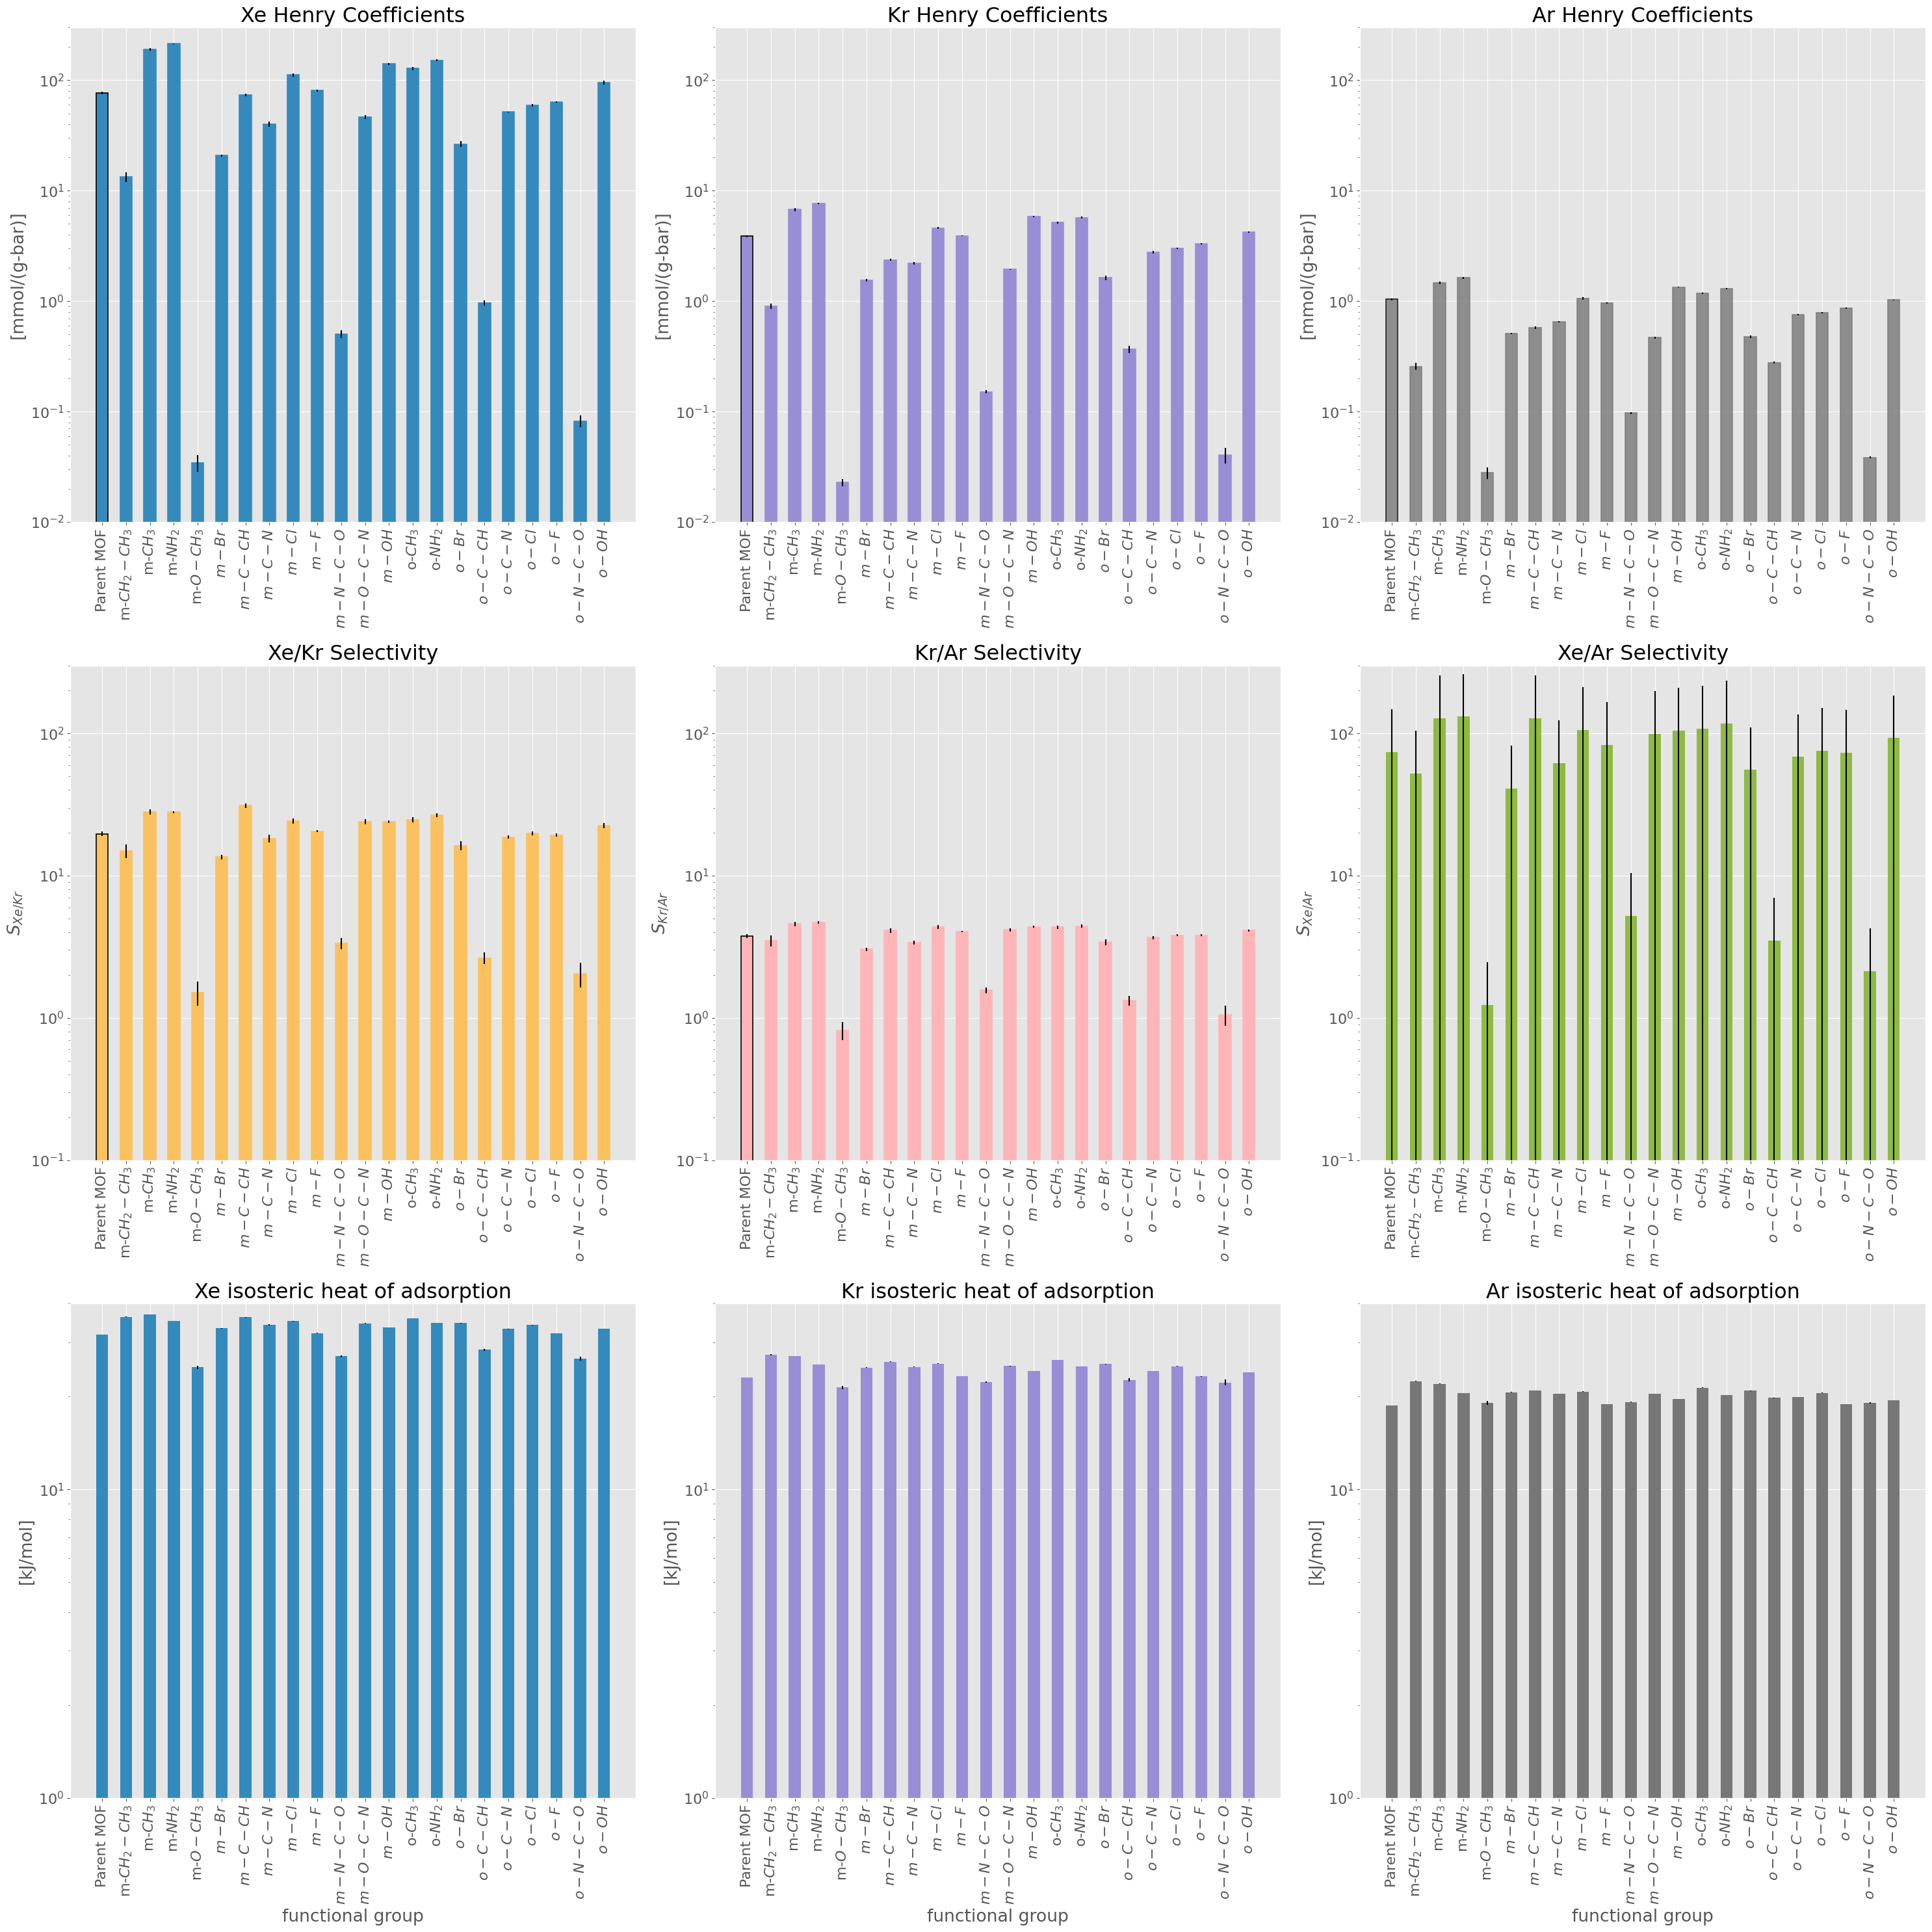

In [15]:
N = length(sorted_names)

fig, axs = plt.subplots(3, 3, figsize=(30, 30))
ind = collect(1:N) 
width = 0.5       

###
# Plot Henry Coefficients
###
# Xenon
xe_err = henry_err_array(henry_results, "Xe")
axs[1].bar(ind, henry_coeff_array(henry_results, "Xe"), yerr=xe_err, 
           width, color=pick_a_color(henry_results, 1),
           edgecolor=pick_an_edgecolor(henry_results, 1),
           linewidth=1.2)
axs[1].set_yscale("log")
axs[1].set_ylim(0.01, 300)
axs[1].set_ylabel("[mmol/(g-bar)]")
# axs[1].set_xlabel("functional group")
axs[1].set_title("Xe Henry Coefficients")
axs[1].set_xticks(ind)
axs[1].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
# axs[1].legend(loc="best", fontsize="x-small")

# Krypton
axs[4].bar(ind, henry_coeff_array(henry_results, "Kr"), yerr=henry_err_array(henry_results, "Kr"),
           width, color=pick_a_color(henry_results, 2), 
           edgecolor=pick_an_edgecolor(henry_results, 2),
           linewidth=1.2)
axs[4].set_ylim(0.01, 300)
axs[4].set_yscale("log")
axs[4].set_ylabel("[mmol/(g-bar)]")
# axs[2].set_xlabel("functional group")
axs[4].set_title("Kr Henry Coefficients")
axs[4].set_xticks(ind)
axs[4].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
# axs[4].legend(loc="best", fontsize="x-small")

# Argon
axs[7].bar(ind, henry_coeff_array(henry_results, "Ar"), yerr=henry_err_array(henry_results, "Ar"),
           width, color=pick_a_color(henry_results, 3), alpha=0.8,
           edgecolor=pick_an_edgecolor(henry_results, 3),
           linewidth=1.2)
axs[7].set_yscale("log")
axs[7].set_ylim(0.01, 300)
axs[7].set_ylabel("[mmol/(g-bar)]")
# axs[7].set_xlabel("functional group")
axs[7].set_title("Ar Henry Coefficients")
axs[7].set_xticks(ind)
axs[7].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
# axs[7].legend(loc="best", fontsize="x-small")

###
# Plot Selectivities
###
axs[2].bar(ind, [s_xekr[key]["Xe/Kr"] for key in sorted_names],
           yerr=[s_xekr[key]["err Xe/Kr"] for key in sorted_names],
           width, color=pick_a_color(henry_results, 4),            
           edgecolor=pick_an_edgecolor(henry_results, 4),
           linewidth=1.2)
axs[2].set_ylim(0.1, 300)
axs[2].set_yscale("log")
axs[2].set_xticks(ind)
axs[2].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
axs[2].set_ylabel(L"S_{Xe/Kr}")
# axs[2].set_xlabel("functional group")
axs[2].set_title("Xe/Kr Selectivity")
# axs[2].legend(loc="best", fontsize="x-small")

axs[5].bar(ind, [s_krar[key]["Kr/Ar"] for key in sorted_names], 
           yerr=[s_krar[key]["err Kr/Ar"] for key in sorted_names],
           width, color=pick_a_color(henry_results, 6),
           edgecolor=pick_an_edgecolor(henry_results, 6),
           linewidth=1.2)
axs[5].set_yscale("log")
axs[5].set_ylim(0.1, 300)
axs[5].set_xticks(ind)
axs[5].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
axs[5].set_ylabel(L"S_{Kr/Ar}")
# axs[5].set_xlabel("functional group")
axs[5].set_title("Kr/Ar Selectivity")
# axs[5].legend(loc="best", fontsize="x-small")

axs[8].bar(ind, [s_xear[key]["Xe/Ar"] for key in sorted_names],
           yerr=[s_xear[key]["Xe/Ar"] for key in sorted_names],
           width, color=pick_a_color(henry_results, 5))
axs[8].set_yscale("log")
axs[8].set_ylim(0.1, 300)
axs[8].set_xticks(ind)
axs[8].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
axs[8].set_ylabel(L"S_{Xe/Ar}")
# axs[8].set_xlabel("functional group")
axs[8].set_title("Xe/Ar Selectivity")
# axs[8].legend(loc="best", fontsize="x-small")

###
#  Plot: isosteric heat of adsorption: "Qst (kJ/mol)"
###
qst_xe_err = heat_of_ads_err_array(henry_results, "Xe")
axs[3].bar(ind, heat_of_ads_array(henry_results, "Xe"), yerr=qst_xe_err,
           width, color=pick_a_color(henry_results, 1))
axs[3].set_yscale("log")
axs[3].set_ylim(1, 40)
axs[3].set_ylabel("[kJ/mol]")
axs[3].set_xlabel("functional group")
axs[3].set_title("Xe isosteric heat of adsorption")
axs[3].set_xticks(ind)
axs[3].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")

qst_kr_err = heat_of_ads_err_array(henry_results, "Kr")
axs[6].bar(ind, heat_of_ads_array(henry_results, "Kr"), yerr=qst_kr_err,
           width, color=pick_a_color(henry_results, 2))
axs[6].set_yscale("log")
axs[6].set_ylim(1, 40)
axs[6].set_ylabel("[kJ/mol]")
axs[6].set_xlabel("functional group")
axs[6].set_title("Kr isosteric heat of adsorption")
axs[6].set_xticks(ind)
axs[6].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")

qst_ar_err = heat_of_ads_err_array(henry_results, "Ar")
axs[9].bar(ind, heat_of_ads_array(henry_results, "Ar"), yerr=qst_ar_err,
           width, color=pick_a_color(henry_results, 3))
axs[9].set_yscale("log")
axs[9].set_ylim(1, 40)
axs[9].set_ylabel("[kJ/mol]")
axs[9].set_xlabel("functional group")
axs[9].set_title("Ar isosteric heat of adsorption")
axs[9].set_xticks(ind)
axs[9].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")

# suptitle(L"NiPyC$_2$ with PBESOL")
tight_layout()
savefig("NiPyC2_pbesol_multipannel_plot_v3.pdf", dpi=300, format="pdf")

### Look at each row of the multi-pannel plot individually

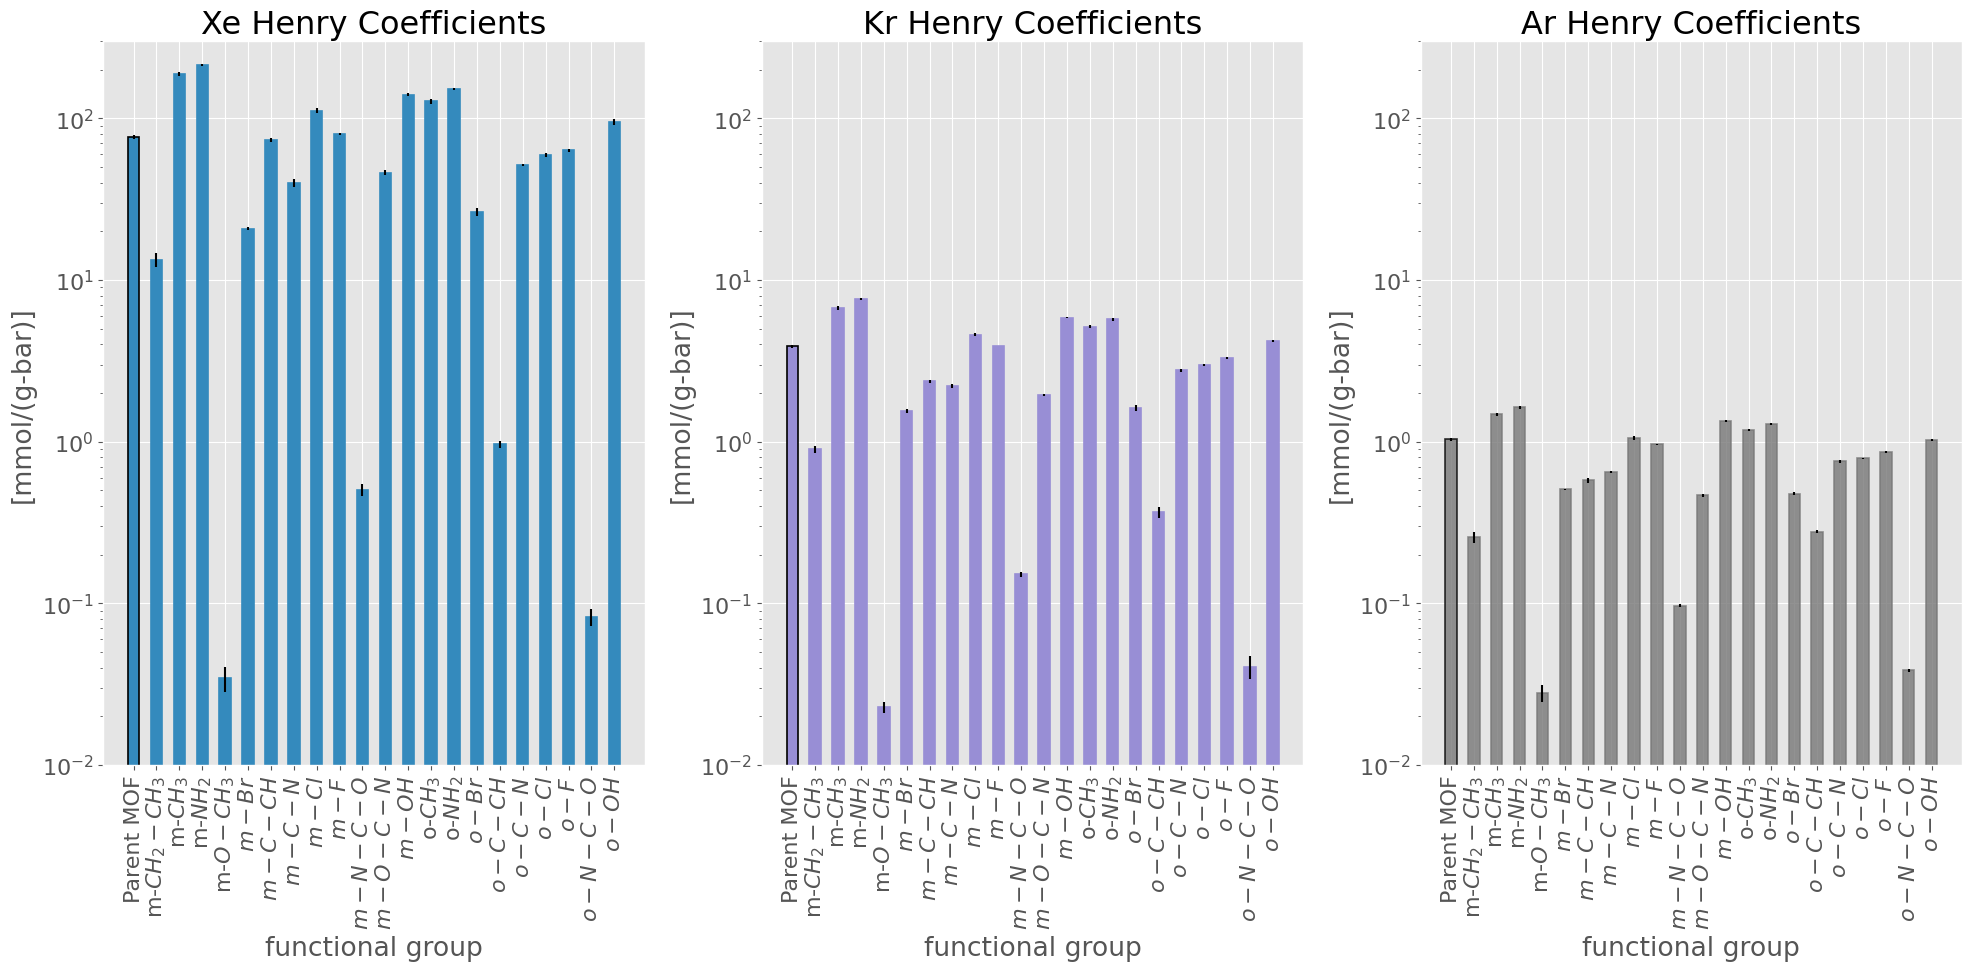

In [16]:
###
# Plot Henry Coefficients
###
N = length(sorted_names)
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
ind = collect(1:N) 
width = 0.5       

for (i, gas) in enumerate(["Xe", "Kr", "Ar"])
    gas_err = henry_err_array(henry_results, gas)
    axs[i].bar(ind, henry_coeff_array(henry_results, gas),
               yerr=gas_err, 
               width, color="C$i",
               alpha=(i==3 ? 0.8 : 1.0),
               edgecolor=pick_an_edgecolor(henry_results, i),
               linewidth=1.2)
    axs[i].set_yscale("log")
    axs[i].set_ylim(0.01, 300)
    axs[i].set_ylabel("[mmol/(g-bar)]")
    axs[i].set_xlabel("functional group")
    axs[i].set_title("$gas Henry Coefficients")
    axs[i].set_xticks(ind)
    axs[i].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
end

tight_layout()
# savefig("NiPyC2_pbesol_multipannel_Henry_Coeff_logplot.pdf", dpi=300, format="pdf")

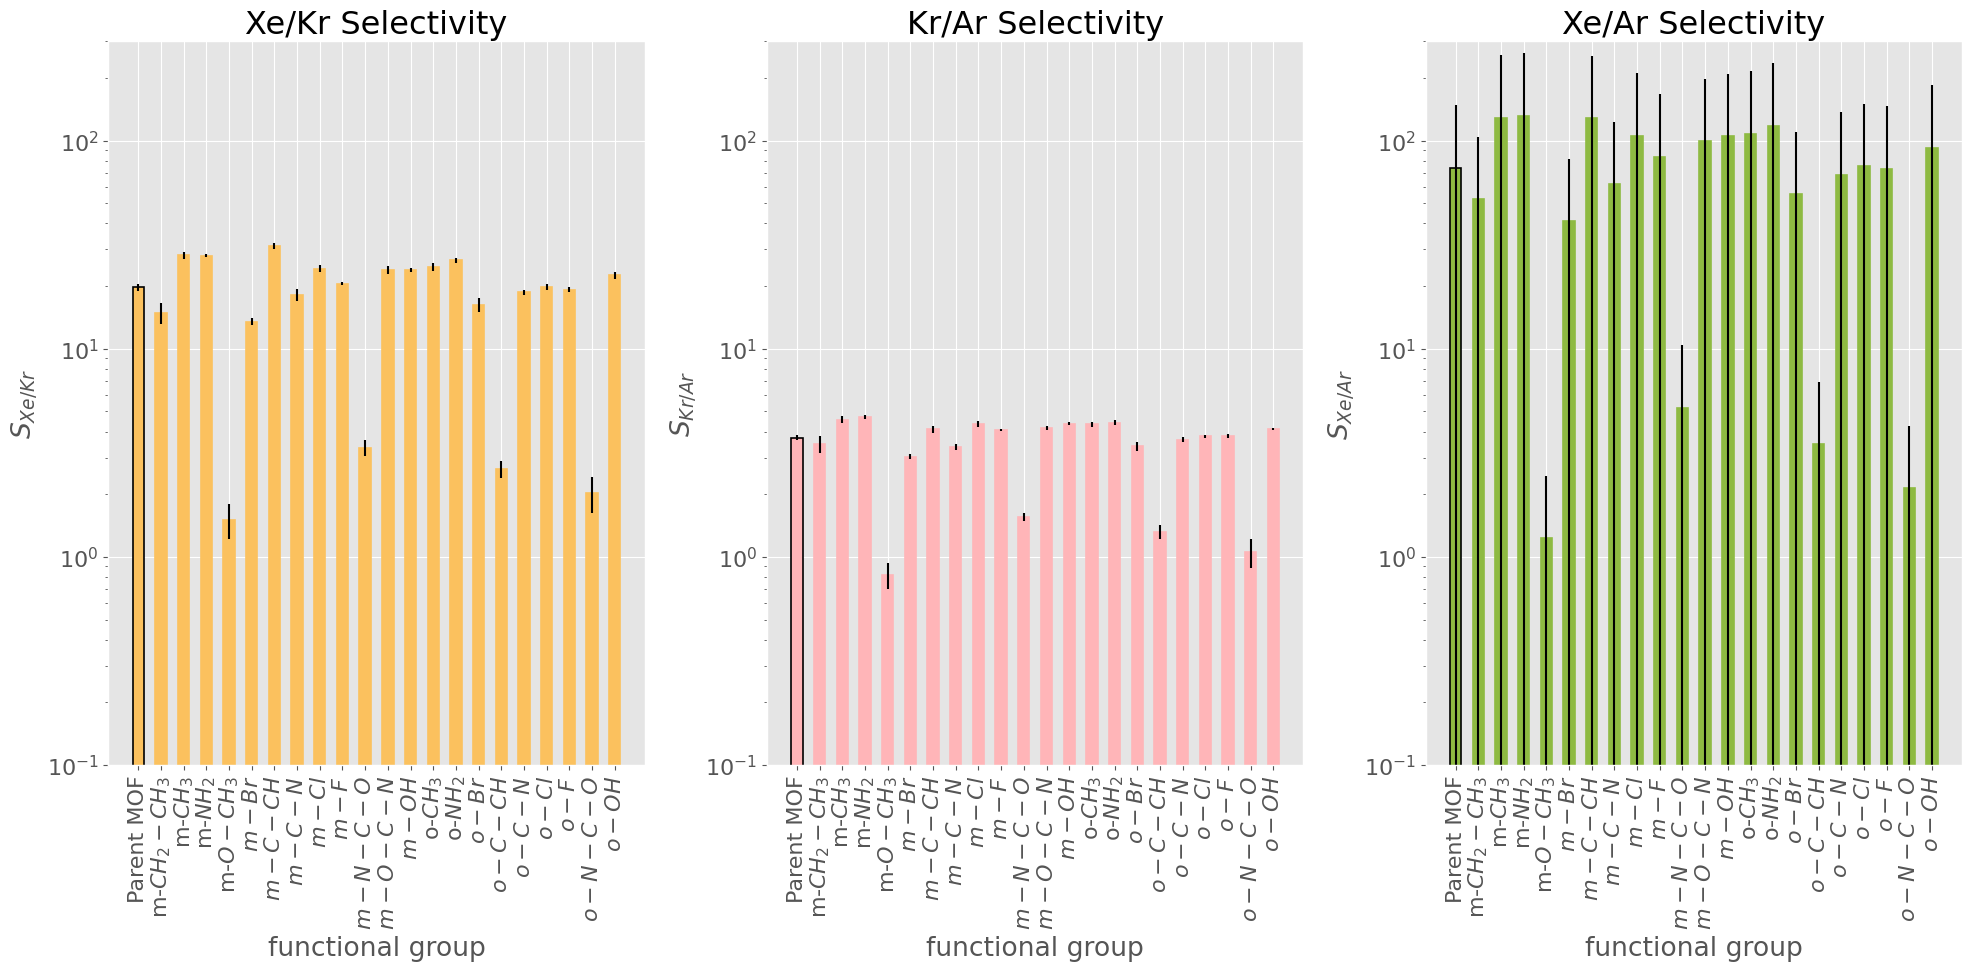

In [17]:
###
# Plot Selectivities
###
N = length(sorted_names)
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
ind = collect(1:N) 
width = 0.5 


# Xenon/Krypton
axs[1].bar(ind, [s_xekr[key]["Xe/Kr"] for key in sorted_names],
           yerr=[s_xekr[key]["err Xe/Kr"] for key in sorted_names],
           width, color=pick_a_color(henry_results, 4),
           edgecolor=pick_an_edgecolor(henry_results, 4),
           linewidth=1.2)
axs[1].set_yscale("log")
axs[1].set_ylim(0.1, 300)
axs[1].set_xticks(ind)
axs[1].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
axs[1].set_ylabel(L"S_{Xe/Kr}")
axs[1].set_xlabel("functional group")
axs[1].set_title("Xe/Kr Selectivity")
# axs[1].legend(loc="best", fontsize="x-small")

# Krypton/Argon
axs[2].bar(ind, [s_krar[key]["Kr/Ar"] for key in sorted_names], 
           yerr=[s_krar[key]["err Kr/Ar"] for key in sorted_names],
           width, color=pick_a_color(henry_results, 6),
           edgecolor=pick_an_edgecolor(henry_results, 6),
           linewidth=1.2)
axs[2].set_yscale("log")
axs[2].set_ylim(0.1, 300)
axs[2].set_xticks(ind)
axs[2].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
axs[2].set_ylabel(L"S_{Kr/Ar}")
axs[2].set_xlabel("functional group")
axs[2].set_title("Kr/Ar Selectivity")
# axs[2].legend(loc="best", fontsize="x-small")

# Xenon/Argon
axs[3].bar(ind, [s_xear[key]["Xe/Ar"] for key in sorted_names],
           yerr=[s_xear[key]["Xe/Ar"] for key in sorted_names],
           width, color=pick_a_color(henry_results, 5),
           edgecolor=pick_an_edgecolor(henry_results, 5),
           linewidth=1.2)
axs[3].set_yscale("log")
axs[3].set_ylim(0.1, 300)
axs[3].set_xticks(ind)
axs[3].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
axs[3].set_ylabel(L"S_{Xe/Ar}")
axs[3].set_xlabel("functional group")
axs[3].set_title("Xe/Ar Selectivity")
# axs[3].legend(loc="best", fontsize="x-small")

yscale("log")
tight_layout()
# savefig("NiPyC2_pbesol_multipannel_Selectivities_logplot.pdf", dpi=300, format="pdf")

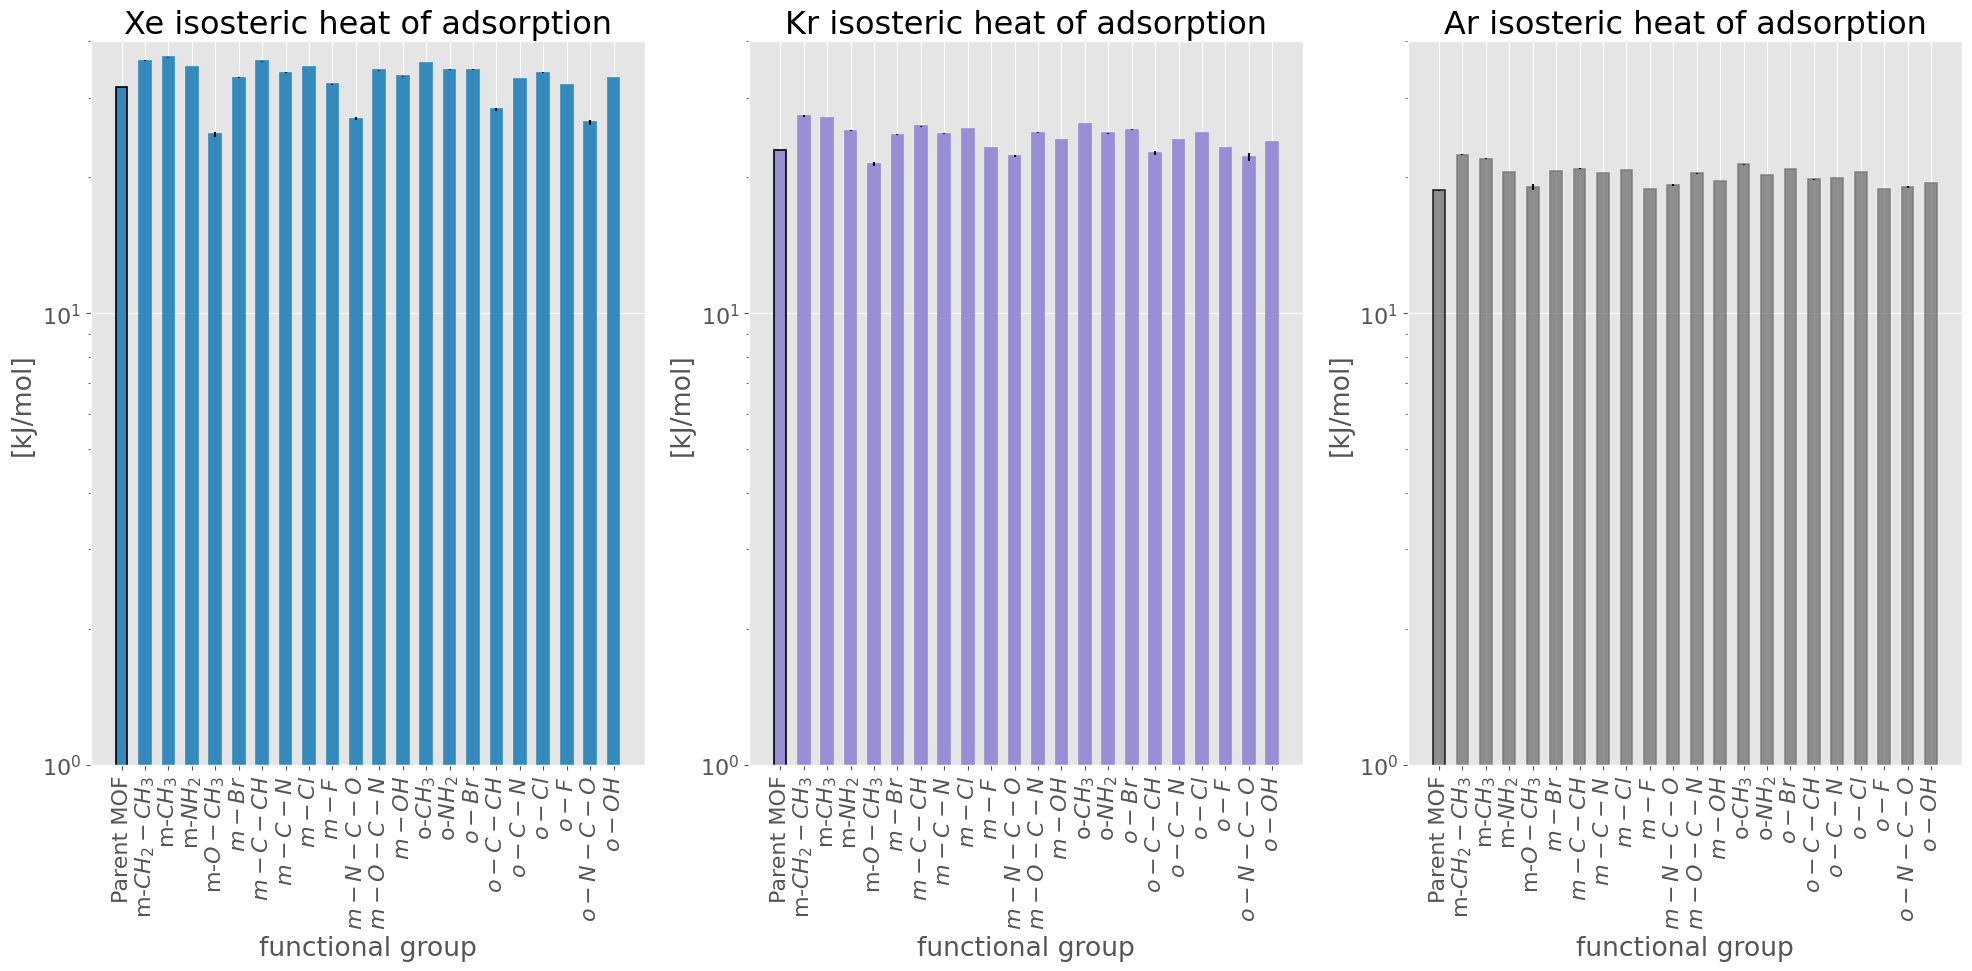

In [18]:
###
#  Plot: isosteric heat of adsorption: "Qst (kJ/mol)"
###
N = length(sorted_names)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
ind = collect(1:N) 
width = 0.5       

for (i, gas) in enumerate(["Xe", "Kr", "Ar"])
    qst_gas_err = heat_of_ads_err_array(henry_results, gas)
    axs[i].bar(ind, heat_of_ads_array(henry_results, gas),
               yerr=qst_gas_err, 
               width, color="C$i",
               alpha=(i==3 ? 0.8 : 1.0),
               edgecolor=pick_an_edgecolor(henry_results, i),
               linewidth=1.2)
    axs[i].set_yscale("log")
    axs[i].set_ylim(1, 40)
    axs[i].set_ylabel("[kJ/mol]")
    axs[i].set_xlabel("functional group")
    axs[i].set_title("$gas isosteric heat of adsorption")
    axs[i].set_xticks(ind)
    axs[i].set_xticklabels([pretty_names[key] for key in sorted_names], rotation="vertical")
end

tight_layout()
# savefig("NiPyC2_pbesol_multipannel_IsoHeatAds_logplot.pdf", dpi=300, format="pdf")

## Henry Coefficient vs. Selectivity

*TODO:* 
- marker code meta and ortho, then remove m-/o- from names
- pair matching meta and ortho groups by color
- increase font size on figure
- tweak `adjust_text` params to remove overlapping labels

to make labels shorter, another thing you can consider is two different symbols, one for meta, one for ortho, then each functional group gets a color. and u label with the functional group only to shorten

In [19]:
name_to_label = copy(sorted_names)
arene_to_marker = [] # pair: "ortho" -> "o", "meta" -> "^", and "Patent MOF" -> "d" 

for i in 1:length(name_to_label)
    # special case: Parent MOF
    if name_to_label[i] == "Parent MOF"
        push!(arene_to_marker, "d")
        @debug println(name_to_label[i], " =>", arene_to_marker[i])
        continue
    end
    
    # determine arene sub before splitting
    if occursin("m-", name_to_label[i])
        push!(arene_to_marker, "^")
        name_to_label[i] = replace(name_to_label[i], "m-" => "")
    elseif occursin("o-", name_to_label[i])
        push!(arene_to_marker, "o")
        name_to_label[i] = replace(name_to_label[i], "o-" => "")
    else
        @warn println("cannot determine arene sub for ", sorted_names[i])
    end
    @debug println(name_to_label[i], " =>", arene_to_marker[i])
end


# different color for each mof
colorful_array = seaborn.color_palette("gist_rainbow", length(unique(name_to_label))) 

for (i, name) in enumerate(unique(name_to_label))
    if name == "Parent MOF"
        xtal_to_color[name] = (0.0, 0.0, 0.0)
        continue
    end
    xtal_to_color["o-" * name] = colorful_array[i]
    xtal_to_color["m-" * name] = colorful_array[i]
end

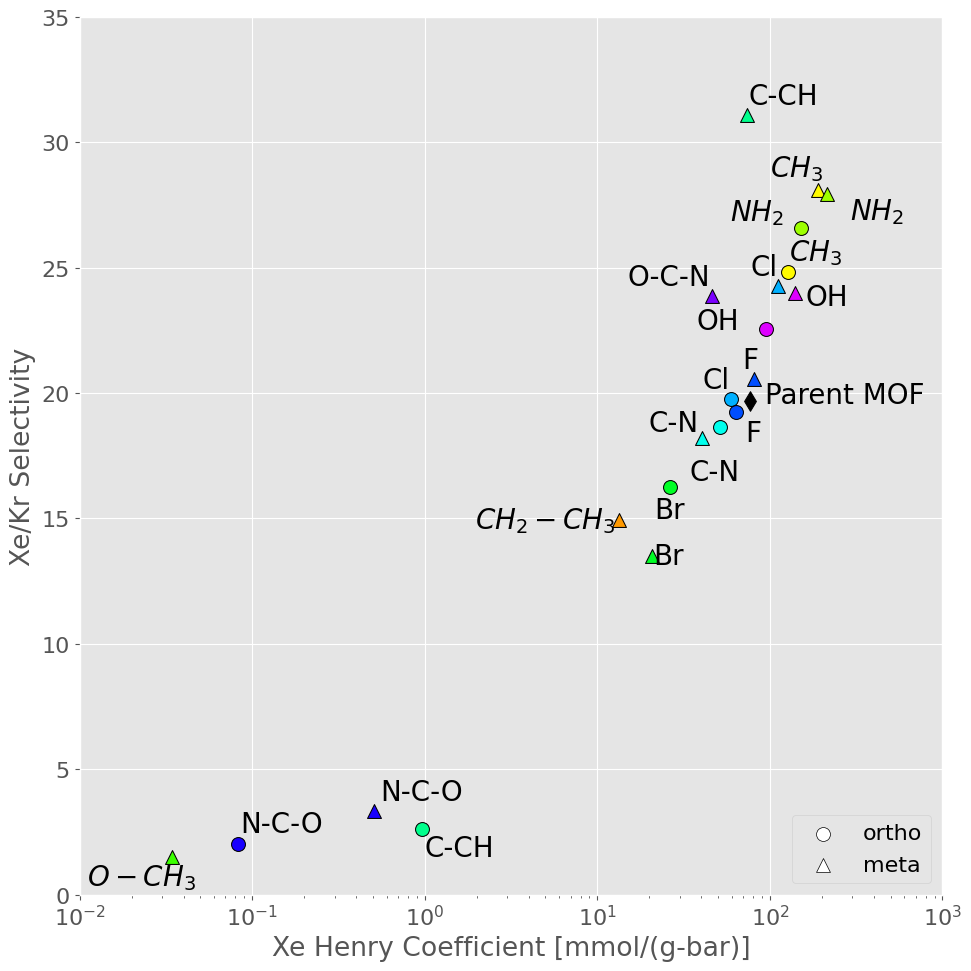

In [20]:
fig, axs = plt.subplots(figsize=(10, 10)) # figsize=(10, 10)

s1 = axs.scatter([], [], marker="o", s=100, label="ortho", color="w", edgecolor="k")
s2 = axs.scatter([], [], marker="^", s=100, label="meta", color="w", edgecolor="k")

# # error bars
# xe_err = henry_err_array(henry_results, "Xe")
# sel_err = [s_xekr[key]["err Xe/Kr"] for key in sorted_names]

for (i, key) in enumerate(sorted_names)
    axs.scatter(henry_coeff_array(henry_results, "Xe")[i],
                s_xekr[key]["Xe/Kr"],
                s=100,
                marker=arene_to_marker[i], 
                linewidths=0.75,
                edgecolors="k",
                color=xtal_to_color[key])
end

texts = [axs.text(henry_coeff_array(henry_results, "Xe")[i],
                    s_xekr[key]["Xe/Kr"], 
                    name_to_label[i],
                    fontsize=20) 
                  for (i, key) in enumerate(sorted_names)]

axs.set_xscale("log")
axs.set_xlim(0.01, 1000)
axs.set_ylim(0.0, 35)

# arrowprops = Dict(:arrowstyle => "->", :color => "k", :lw => 0.5)
adjustText.adjust_text(texts, 
                    expand_text=(1.05, 1.2),
                    expand_points=(1.05, 1.2),
                    expand_objects=(1.05, 1.2),
                    expand_align=(1.05, 1.2),
                    autoalign="x",
                    force_text=(0.1, 0.25),
                    force_points=(0.2, 0.5),
                    force_objects=(0.1, 0.25),
                    lim=2500,
                    precision=0.01,
                    avoid_text=true,
                    avoid_points=true,
                    avoid_self=true)



legend([s1, s2], ["ortho", "meta"], loc="lower right")

axs.grid("on")
# axs.set_facecolor("C3")

# axs.set_title(L"H$_{Xe}$ vs S$_{Xe/Kr}$")
axs.set_xlabel("Xe Henry Coefficient [mmol/(g-bar)]")
axs.set_ylabel("Xe/Kr Selectivity")

tight_layout()
# savefig("H_xe_vs_Sel_XeKr.pdf", dpi=300, format="pdf")

## Isoteric Heat of Adsorption Correlation Plots

Note: We model each adsorbate as a sphere with a different (i) size and (ii) attractive potential well. thus, since each adsorbate is the same shape, it isn't too surprising that the heats of adsorption of Xe and Kr are well-correlated in the MOFs.

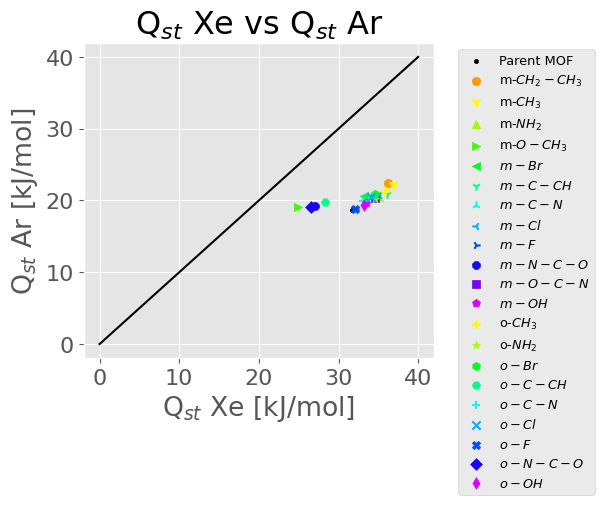

In [21]:
# scatter plots with x=y line
# Qst Xe vs Qst Ar
figure()
xy_line = [i for i in 0:1:40]
qst_xe = heat_of_ads_array(henry_results, "Xe")
qst_ar = heat_of_ads_array(henry_results, "Ar")

for key in sorted_names
    scatter(henry_results[key]["Xe"]["Qst (kJ/mol)"],
            henry_results[key]["Ar"]["Qst (kJ/mol)"],
            marker=xtal_to_marker[key],
            color=xtal_to_color[key],
            label=pretty_names[key])
end
plot(xy_line, xy_line, color="k")

title(L"Q$_{st}$ Xe vs Q$_{st}$ Ar")
legend(bbox_to_anchor=(1.05, 1), fontsize="xx-small")

xlabel(L"Q$_{st}$ Xe [kJ/mol]")
ylabel(L"Q$_{st}$ Ar [kJ/mol]")

tight_layout()
# savefig("NiPyC2_pbesol_Qst_Xe_vs_Ar.pdf", dpi=300, format="pdf")

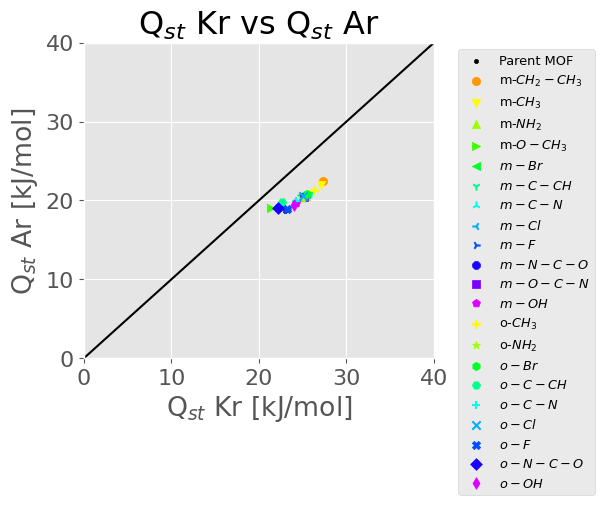

In [22]:
# Qst Kr vs Qst Ar
figure()
for key in sorted_names
    scatter(henry_results[key]["Kr"]["Qst (kJ/mol)"],
            henry_results[key]["Ar"]["Qst (kJ/mol)"],
            marker=xtal_to_marker[key],
            color=xtal_to_color[key],
            label=pretty_names[key])
end
plot(xy_line, xy_line, color="k")

xlim(0, 40)
ylim(0, 40)

title(L"Q$_{st}$ Kr vs Q$_{st}$ Ar")
legend(bbox_to_anchor=(1.05, 1), fontsize="xx-small")

xlabel(L"Q$_{st}$ Kr [kJ/mol]")
ylabel(L"Q$_{st}$ Ar [kJ/mol]")

tight_layout()
# savefig("NiPyC2_pbesol_Qst_Kr_vs_Ar.pdf", dpi=300, format="pdf")

## Plot Isotherms

In [23]:
# function experimental_isotherm_data(adsorbate::String, fgroup::String="")
#     # which adsorbate to consider 
#     if adsorbate == "Xe" && fgroup == ""
#         filename = "NiMOF-2_Xe_298K.csv"
#         @info filename
#     elseif adsorbate == "Kr" && fgroup == ""
#         filename = "NiMOF2_Kr_298K.csv"
#         @info filename
#     elseif adsorbate == "Xe" && fgroup == "NH2"
#         filename = "Ni-PYC-NH2_Xe.csv"
# #         filename = "NH2_Xe.csv"
#         @info filename
#     else
#         error("define experimental data file to use")
#     end
    
#     # find and read the experimental data file
#     wheres_exptl_data = joinpath(PorousMaterials.PATH_TO_DATA,
#         "experimental_isotherm_data", filename)

#     df_exptl_data = CSV.read(wheres_exptl_data)
#     # apply necessary unit conversions
#     # 1 bar = 0.986923 atm
#     bar_per_atm = 1/0.986923; # bar/atm
#     df_exptl_data[!, Symbol("pressure (bar)")] = vcat(df_exptl_data[!, Symbol("p/p0")] * bar_per_atm)
#     rename!(df_exptl_data, Symbol("mmol/g") => Symbol("⟨N⟩ (mmol/g)"))
      
#     desorp_onset = argmax(df_exptl_data[!, :p]) # onset of desorption

#     df_exptl_data = df_exptl_data[1:desorp_onset, [Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
#     push!(df_exptl_data, [0.0, 0.0])
#     sort!(df_exptl_data, Symbol("pressure (bar)"))
#     return df_exptl_data
# end


# function read_sim_data(props::Array{String, 1}, framework::String, gas::String, temp::Float64, 
#                         ffield::String, press::Array{Float64}, nburn::Int64, nsample::Int64)
#     xtal = Crystal(framework)
#     mol = Molecule(gas)
#     ljff = LJForceField(ffield)
#     df_sim = isotherm_sim_results_to_dataframe(props, xtal, mol, temp, press, ljff, nburn, nsample)
#     push!(df_sim, [0.0, 0.0, 0.0]) ### add point at origin ###
#     sort(df_sim, Symbol("pressure (bar)"))
# end

# # scaling factor used for MOFs with different crystal densities 
# function adsorption_scale_factor(mof::String)
#     xtal = Crystal(mof)
#     strip_numbers_from_atom_labels!(xtal)
# #         @assert length(frameworks) == 1
#     adsorption_scale_factor = 6.02214 * crystal_density(xtal) * xtal.box.Ω * 10^(-7)
#     return adsorption_scale_factor
# end

In [24]:
# @eval PorousMaterials PATH_TO_CRYSTALS = joinpath("/home/ng/DTRA/structural_relaxation/post-relaxation_cifs/")

# # frameworks to plot
# # frameworks = ["NiPyC2_experiment.cif"]

# frameworks = ["Parent MOF"]

# labels_mof = Dict(zip(frameworks, ["Ni(PyC)"*L"_2"]))

# adsorbate_to_color = Dict(zip(["Xe", "Kr"], ["C0", "C1"]))
# adsorbate_to_marker = Dict(zip(["Xe", "Kr"], ["v", "D"]))

# data_marker = Dict(zip([1, 2, 3, 4, 5],["", "X", "v", "P", "D"]))

# # labels for each MOF
# mof_to_marker = Dict(zip(frameworks, ["x", "s", "P", "o", "*", ">"]))
# # mof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))

# # labels for each experimental data set
# labels_exp = Dict("Xe" => "Xe experiment", "Kr" => "Kr experiment") #  => "Xe experiment"
# exp_data_to_marker = Dict(zip(["", "NH2"], ["v", "D"]))
# exp_data_to_color = Dict(zip(["", "NH2"], ["g", "b"]))

# # labels for adsorbate used
# labels_gas = Dict("Xe" => "Xe simulation", "Kr" => "Kr simulation") # => "Xe simulation"

In [25]:
# isotherm_results["Parent MOF"]["Xe"]

In [26]:
# ###
# # adsorption per unit cell
# ###
# adsorption_per_unit_cell = true
# ads_scale_factor = 1.0

# ###
# # Create Figure
# ###
# fig, ax1 = plt.subplots() # create the figure as a subplot

# # create an array for plot handles
# plts = Array{Any, 1}(undef, 5)
# nn = 1

# # create an empty plot object to place T=298 K in legend
# plts[nn] = ax1.scatter([], [], label="T = 298 K", marker=data_marker[nn], color="")


# for gas in ["Xe", "Kr"] #adsorbate
#     for mof in ["Parent MOF"] #frameworks
#         # increment plot index
#         nn += 1 
        
#         # reset ads_scale_factor
#         ads_scale_factor = 1.0 

#         # load in simulation data
# #         df_sim = read_sim_data(props_we_want, mof, gas, temp, ljff.name, pressures, nburn, nsample)
# #         df_sim = isotherm_results[mof][gas]
        
#         # plot uptake mmol/g 
#         plts[nn] = ax1.plot(isotherm_results[mof][gas][:, Symbol("pressure (bar)")], 
#                             isotherm_results[mof][gas][:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
#                             label=labels_gas[gas],
#                             marker=data_marker[nn],
#                             markersize=8,
#                             markeredgecolor="black",
#                             markeredgewidth=0.1,
#                             color=adsorbate_to_color[gas],
#                             clip_on=false)
#     end
#     # increment plot index
#     nn += 1 
    
#     # reset ads_scale_factor
#     ads_scale_factor = 1.0 
    
#     # load exptl data
#     df_exp = experimental_isotherm_data(gas) # default fgroup=""
#     # plot exptl data
#     plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
#                             df_exp[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
#                             label=labels_exp[gas],
#                             marker=data_marker[nn],
#                             color=adsorbate_to_color[gas],
#                             clip_on=false)
# end

# ads_scale_factor = adsorption_scale_factor("NiPyC2_experiment.cif")


# # title(L"Ni(PyC)$_2$ simulation vs. experiment")
# # ["T = 298 K", "Xe simulation", "Xe experiment", "Kr simulation", "Kr experiment"],
# legend((plts[1], plts[2][1], plts[3], plts[4][1], plts[5]),
#             ["T = 298 K", "Xe simulation", "Xe experiment", "Kr simulation", "Kr experiment"],
#             loc="lower right", fontsize="xx-small") 

# ax1.grid("on")
# ax1.set_xlabel("pressure [bar]")
# ax1.set_ylabel("uptake [mmol/g]")

# ymin = -0.04
# ymax = 4
# ax1.set_ylim(ymin, ymax)


# xmin = -0.01
# xmax = pressures[end] + 0.01
# ax1.set_xlim(xmin, xmax)

# ax1.axhline(y=2/ads_scale_factor, linestyle="--", color="0.4")
# ax1.text(0.02, 2/ads_scale_factor+0.04, "2 adsorbates/unit cell", color="0.4", fontsize=9)

# tight_layout()
# # savefig("NiPyC2_isotherms_sim_vs_exp_UFF.pdf", dpi=300, format="pdf")

In [27]:
# make a plot with all of the Xe isotherms and a separate one with all of the Kr isotherms